In [ ]:
! pip install SimpleITK
! pip install nibabel

In [33]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [2]:
# %run "utils.ipynb"

%run "C:\Users\johnm\Downloads\utils.ipynb"  #tarang

# Visualizing one image

In [ ]:
# image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

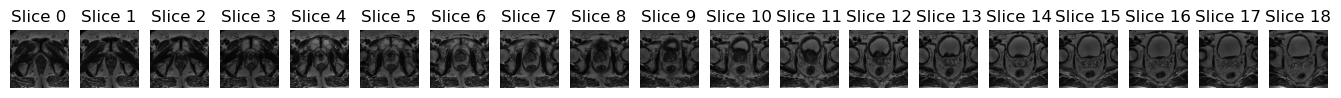

In [ ]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Merging images with label in one dictionary

In [ ]:
# directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
# directory = "../data/picai_public_images_fold1"
directory = "../data/image/"

In [4]:
# tarang updated this to make it a function

def make_dict(directory, multi_fold = False, dict_images = {}):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      make_dict(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if "t2w" in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'age_group': None, 'patient_id': None}
    return dict_images


In [ ]:
dict_images = {}

# previous code:

#one folder only
# dict_images = make_dict(directory, False, dict_images)

# all folders
dict_images = make_dict(directory, True, dict_images)

fold
../data/image/picai_public_images_fold1
datapoint
../data/image/picai_public_images_fold0
datapoint
../data/image/picai_public_images_fold2
datapoint
../data/image/picai_public_images_fold3
datapoint
../data/image/picai_public_images_fold4
datapoint


In [5]:
dict_images = {}

directory = "D:\Downloads\Luna Training Data"
folds = os.listdir(directory)

# print(folds)

dict_images = make_dict(directory, True, dict_images)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\johnm\AppData\Local\Temp\ipykernel_18940\2235566032.py:3: SyntaxWarning: invalid escape sequence '\D'
  directory = "D:\Downloads\Luna Training Data"


fold
D:\Downloads\Luna Training Data\picai_public_images_fold0
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold1
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold2
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold3
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold4
datapoint


In [6]:
print(list(dict_images.keys())[0])

dict_images[list(dict_images.keys())[0]]

10000_1000000


{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80885080> >,
 'case_pca': None,
 'patient_age': None,
 'age_group': None,
 'patient_id': None}

In [7]:
#size of the dictionary
len(dict_images)

1500

We stored 3 things:
* the nii files that have the color coded images
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Opening nii files

In [ ]:
# path = '../10035_1000035.nii'


In [ ]:
# img = nib.load(path).get_fdata()
# img.shape

In [ ]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [ ]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [8]:
# tarang

labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"

<>:3: SyntaxWarning: invalid escape sequence '\j'
<>:3: SyntaxWarning: invalid escape sequence '\j'
C:\Users\johnm\AppData\Local\Temp\ipykernel_18940\299217126.py:3: SyntaxWarning: invalid escape sequence '\j'
  labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"


In [ ]:
# labels_path = "../marksheet.csv"
labels_path = "../data/marksheet.csv"

In [9]:
df = pd.read_csv(labels_path)

In [10]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [11]:
df['case_csPCa'].value_counts()

case_csPCa
NO     1075
YES     425
Name: count, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [12]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [13]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [14]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

### Creating a new variable for age group (multimodal purposes)

In [15]:
def categorize_age(age):
    if age < 65:
        return '<65'
    else:
        return '65+'

# Apply the function to create a new column for age group
df['age_group'] = df['patient_age'].apply(categorize_age)

# Count occurrences of each age group
age_group_counts = df['age_group'].value_counts()

# Display the counts
print(age_group_counts)

age_group
65+    869
<65    631
Name: count, dtype: int64


## Adding to a dictionary based on their full name

In [16]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        age_group = categorize_age(patient_age)
        dict_images[f]['age_group'] = age_group

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Found 10000_1000000
Found 10001_1000001
Found 10002_1000002
Found 10003_1000003
Found 10004_1000004
Found 10005_1000005
Found 10006_1000006
Found 10007_1000007
Found 10008_1000008
Found 10009_1000009
Found 10010_1000010
Found 10011_1000011
Found 10012_1000012
Found 10013_1000013
Found 10014_1000014
Found 10015_1000015
Found 10016_1000016
Found 10017_1000017
Found 10018_1000018
Found 10019_1000019
Found 10020_1000020
Found 10021_1000021
Found 10022_1000022
Found 10023_1000023
Found 10024_1000024
Found 10025_1000025
Found 10026_1000026
Found 10027_1000027
Found 10028_1000028
Found 10029_1000029
Found 10030_1000030
Found 10031_1000031
Found 10032_1000032
Found 10033_1000033
Found 10034_1000034
Found 10035_1000035
Found 10036_1000036
Found 10037_1000037
Found 10038_1000038
Found 10039_1000039
Found 10040_1000040
Found 10041_1000041
Found 10042_1000042
Found 10043_1000043
Found 10044_1000044
Found 10045_1000045
Found 10046_1000046
Found 10047_1000047
Found 10048_1000048
Found 10049_1000049


In [17]:
found, not_found

(1500, 0)

In [18]:
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80885080> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80884FF0> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': '<65',
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F8068D2C0> >,
  'case_pca': 0,
  'patient_age': 72,
  'age_group': '65+',
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F808850B0> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of typ

### Evaluating class imbalance in final sample

In [ ]:



# ### THIS HAS ALL BEEN PUT INTO FUNCTIONS BELOW BECAUSE IT WAS NEEDED FOR THE YOUNG/OLD DICTS AS WELL :)




# # Extract 'case_pca' values from dictionary values
# case_pca_values = [item['case_pca'] for item in dict_images.values()]

# # Count occurrences of 'YES' and 'NO'
# counts = Counter(case_pca_values)
# yes_count = counts[1]
# no_count = counts[0]

# print(f"Count of 'YES': {yes_count}")
# print(f"Count of 'NO': {no_count}")

# # trying to balance
# balanced = {}

# positives = {}
# for k in dict_images.keys():
#   balanced[k] = dict_images[k]
#   if dict_images[k]['case_pca'] == 1:
#     positives[k] = dict_images[k]

# repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

# for r in range(len(repeats)):
#   balanced[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
#   print("repeating " + repeats[r])

# # check if correctly done
# case_pca_values = [item['case_pca'] for item in balanced.values()]

# # Count occurrences of 'YES' and 'NO'
# counts = Counter(case_pca_values)
# yes_count = counts[1]
# no_count = counts[0]

# print(f"Count of 'YES': {yes_count}")
# print(f"Count of 'NO': {no_count}")

In [19]:
def balance_checker(current_dictionary, return_counts = False):
    # Extract 'case_pca' values from dictionary values
    case_pca_values = [item['case_pca'] for item in current_dictionary.values()]

    # Count occurrences of 'YES' and 'NO'
    counts = Counter(case_pca_values)
    yes_count = counts[1]
    no_count = counts[0]

    if return_counts:
        return yes_count, no_count
    else:
        print(f"Count of 'YES': {yes_count}")
        print(f"Count of 'NO': {no_count}")


# def balance_dataset(current_dictionary):
#     yes_count, no_count = balance_checker(current_dictionary, return_counts = True)
#     balanced_dic = {}
#     positives = {}
#     for k in current_dictionary.keys():
#         balanced_dic[k] = current_dictionary[k]
#         if current_dictionary[k]['case_pca'] == 1:
#             positives[k] = current_dictionary[k]

#     repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

#     for r in range(len(repeats)):
#         balanced_dic[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
#         # print("Repeating " + repeats[r])

#     return balanced_dic

In [20]:
def balance_dataset(current_dictionary, sampling='upsampling'):
    yes_count, no_count = balance_checker(current_dictionary, return_counts=True)
    balanced_dic = {}
    positives = {}
    for k in current_dictionary.keys():
        balanced_dic[k] = current_dictionary[k]
        if current_dictionary[k]['case_pca'] == 1:
            positives[k] = current_dictionary[k]

    if sampling == 'upsampling':
        repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

        for r in range(len(repeats)):
            balanced_dic[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]


    elif sampling == 'downsampling':
        # If downsampling, randomly remove instances from the majority class
        if no_count > yes_count:
            to_remove = random.sample([k for k, v in balanced_dic.items() if v['case_pca'] == 0], no_count - yes_count)
            for key in to_remove:
                del balanced_dic[key]

    return balanced_dic

In [21]:
balanced = balance_dataset(dict_images)

In [ ]:
balance_checker(dict_images)

Count of 'YES': 425
Count of 'NO': 1075


In [22]:
balance_checker(balanced)

Count of 'YES': 1075
Count of 'NO': 1075


In [23]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80885080> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80884FF0> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': '<65',
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F8068D2C0> >,
  'case_pca': 0,
  'patient_age': 72,
  'age_group': '65+',
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F808850B0> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of typ

In [24]:
# balanced dictionary

balanced

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80885080> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80884FF0> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': '<65',
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F8068D2C0> >,
  'case_pca': 0,
  'patient_age': 72,
  'age_group': '65+',
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F808850B0> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': '65+',
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of typ

In [25]:
dict_images[list(dict_images.keys())[0]]

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020F80885080> >,
 'case_pca': 0,
 'patient_age': 73,
 'age_group': '65+',
 'patient_id': '10000_1000000'}

# Image Processing and Train Test Split

In [26]:
def preprocess_data(data):
    images, labels, ages = [], [], []

    for entry in data.values():
        image = forresnet(entry['image'])
        label = entry['case_pca']
        age = entry['patient_age']
        images.append(image)
        labels.append(label)
        ages.append(age)

    X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size = 0.2, random_state = 42)

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    age_train = np.array(age_train)
    age_val = np.array(age_val)
    age_test = np.array(age_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test = preprocess_data(balanced)

Streaming output truncated to the last 5000 lines.
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
S

### Evaluating class imbalance in train, test, and validation sets

In [28]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({1: 697, 0: 679})
Validation Label Counts: Counter({0: 180, 1: 164})
Test Label Counts: Counter({0: 216, 1: 214})


In [29]:
X_train.shape, X_val.shape, X_test.shape

((1376, 224, 224, 3), (344, 224, 224, 3), (430, 224, 224, 3))

# Baseline Model: ResNet50

In [ ]:
# model = tf.keras.applications.ResNet50()

In [ ]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10


2024-05-11 10:16:16.315724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 9s 822ms/step - loss: 0.7309 - accuracy: 0.5674 - val_loss: 0.6506 - val_accuracy: 0.5211
Epoch 2/10
9/9 [==============================] - 7s 742ms/step - loss: 0.6598 - accuracy: 0.5638 - val_loss: 0.6207 - val_accuracy: 0.5915
Epoch 3/10
9/9 [==============================] - 6s 729ms/step - loss: 0.5885 - accuracy: 0.6667 - val_loss: 0.6028 - val_accuracy: 0.6056
Epoch 4/10
9/9 [==============================] - 7s 843ms/step - loss: 0.5625 - accuracy: 0.6809 - val_loss: 0.6751 - val_accuracy: 0.6761
Epoch 5/10
9/9 [==============================] - 7s 789ms/step - loss: 0.5340 - accuracy: 0.7163 - val_loss: 0.5904 - val_accuracy: 0.6056
Epoch 6/10
9/9 [==============================] - 7s 758ms/step - loss: 0.5014 - accuracy: 0.7447 - val_loss: 0.5939 - val_accuracy: 0.6056
Epoch 7/10
9/9 [==============================] - 7s 751ms/step - loss: 0.4745 - accuracy: 0.7837 - val_loss: 0.5707 - val_accuracy: 0.6620
Epoch 8/10
9/9 [===============

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3/3 [==============================] - 2s 537ms/step - loss: 0.6180 - accuracy: 0.6517
Test accuracy: 0.6516854166984558


## Performance Evaluation

3/3 [==============================] - 2s 541ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.797872,0.721053,0.971631,0.827795
Validation,0.732394,0.651163,0.875000,0.746667
Test,0.651685,0.626866,0.875000,0.730435


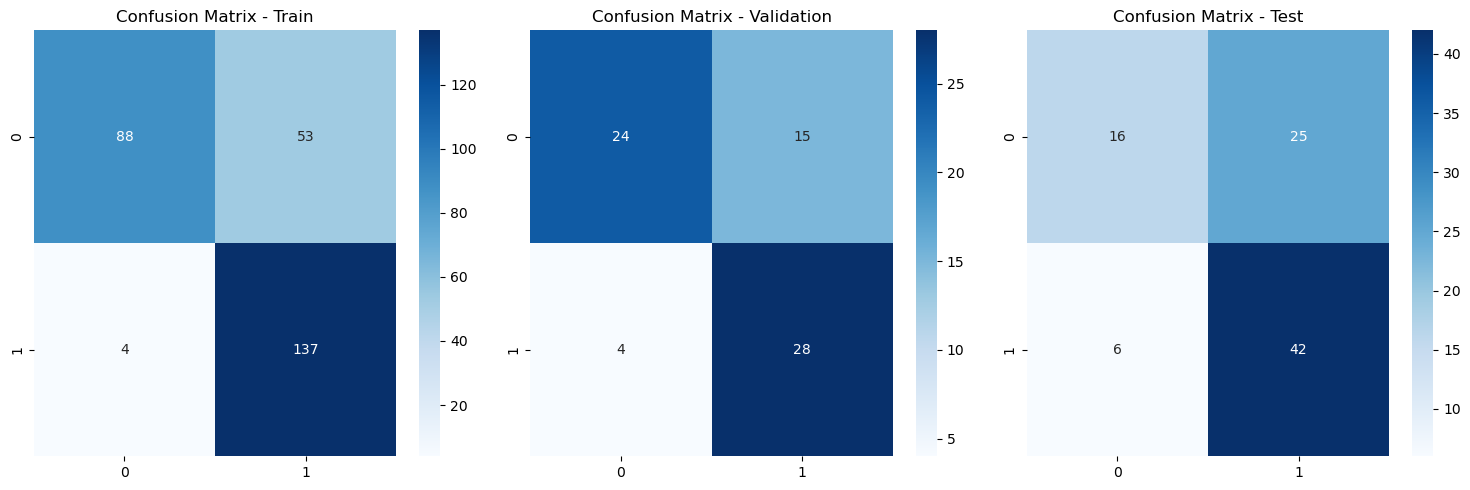

In [ ]:
metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

# Experiment 1: Hyperparameter Training

In [ ]:
# for upsampling and downsampling:

# learning rates: (0.01, 0.005, 0.001, 0.0001?)
# batch size (16, 32, 64)
# epochs (10, 40, 70)

In [39]:
# function form of model code above

def get_model(learning_rate, verbose = False):
  # Load pre-trained ResNet-50 model without top layers
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
    layer.trainable = False

  # Add new classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = Dense(128, activation='relu')(x)  # Add a dense layer
  predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

  # Combine the base model and new layers
  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

  # Print model summary
  if verbose:
    model.summary()

  return model


In [40]:
lrs = [0.01, 0.005, 0.001, 0.0001]
batches = [16, 32, 64]
epochs = [10, 40, 70]

up_lrs = {}
up_epochs ={}
up_batches = {}

down_lrs = {}
down_epochs = {}
down_batches = {}

## Upsampled Data Hyper-parameter Training

In [41]:
for lr in lrs:
  print("training with lr: ", lr)
  model = get_model(lr)

  # Train the model
  history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

  up_lrs[lr] = model

training with lr:  0.01
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 910ms/step - accuracy: 0.4886 - loss: 1.6037 - val_accuracy: 0.5523 - val_loss: 0.6827
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 883ms/step - accuracy: 0.5621 - loss: 0.6783 - val_accuracy: 0.5640 - val_loss: 0.6787
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 905ms/step - accuracy: 0.5901 - loss: 0.6677 - val_accuracy: 0.5872 - val_loss: 0.6645
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 918ms/step - accuracy: 0.6089 - loss: 0.6449 - val_accuracy: 0.5669 - val_loss: 0.6817
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 950ms/step - accuracy: 0.6083 - loss: 0.6400 - val_accuracy: 0.6337 - val_loss: 0.6465
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 967ms/step - accuracy: 0.6915 - loss: 0.6133 - val_accuracy: 0.5785 - val_loss: 0.6651
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 993ms/step - accuracy: 0.6383 - loss: 0.6401 - val_accuracy: 0.6483 - val_loss: 0.6374
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6537 - lo

In [42]:
for batch in batches:
  print("training with batch size: ", batch)
  model = get_model(0.001)

  # Train the model
  history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=batch,
                    validation_data=(X_val, y_val))

  up_batches[batch] = model

training with batch size:  16
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 531ms/step - accuracy: 0.5081 - loss: 0.7455 - val_accuracy: 0.5610 - val_loss: 0.6896
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 373ms/step - accuracy: 0.5928 - loss: 0.6567 - val_accuracy: 0.5669 - val_loss: 0.6795
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.6025 - loss: 0.6516 - val_accuracy: 0.6105 - val_loss: 0.6525
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.6462 - loss: 0.6160 - val_accuracy: 0.6017 - val_loss: 0.6528
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - accuracy: 0.6454 - loss: 0.6113 - val_accuracy: 0.6366 - val_loss: 0.6270
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 515ms/step - accuracy: 0.6851 - loss: 0.5879 - val_accuracy: 0.6483 - val_loss: 0.6225
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.6931 - loss: 0.5764 - val_accuracy: 0.5756 - val_loss: 0.6865
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.

In [47]:
for epoch in epochs:
  print("training with epochs: ", epoch)
  model = get_model(0.001)

  # Train the model
  history = model.fit(X_train, y_train,
                    epochs=epoch,
                    batch_size=32,
                    validation_data=(X_val, y_val))

  up_epochs[epoch] = model

training with epochs:  10
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 920ms/step - accuracy: 0.4921 - loss: 0.7765 - val_accuracy: 0.5669 - val_loss: 0.6769
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 886ms/step - accuracy: 0.5940 - loss: 0.6634 - val_accuracy: 0.5669 - val_loss: 0.6818
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 886ms/step - accuracy: 0.5714 - loss: 0.6772 - val_accuracy: 0.5872 - val_loss: 0.6729
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 903ms/step - accuracy: 0.6464 - loss: 0.6303 - val_accuracy: 0.6192 - val_loss: 0.6529
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 891ms/step - accuracy: 0.6565 - loss: 0.6221 - val_accuracy: 0.6308 - val_loss: 0.6431
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 899ms/step - accuracy: 0.6435 - loss: 0.6247 - val_accuracy: 0.6395 - val_loss: 0.6331
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 870ms/step - accuracy: 0.6709 - loss: 0.6018 - val_accuracy: 0.6337 - val_loss: 0.6368
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 880ms/step - accuracy: 0.7206

# THINGS HERE DOWN MAY NEED EDITED WITH NON UP-SAMPLED TEST DATA



*   recalculate test accuracies with non-upsampled test data
*   re-train the best upsampled model if hyperparameters change
*   retrain best down-sampled model with best hyperparameters
*   evaluate retrained model with non up/down sampled data (can we evaluate both on the same test set?)
*   decide on best model overall
*   all of this may need to be re-run? but the code should stay consistent!


In [49]:
test_metrics = {}

for lr in lrs:
  print("learning rate: ", lr)
  test_loss, test_acc = up_lrs[lr].evaluate(X_test, y_test)
  test_metrics["lr" + str(lr)] = {'loss' : test_loss,
                             'accuracy' : test_acc}

for batch in batches:
  print("batch size: ", batch)
  test_loss, test_acc = up_batches[batch].evaluate(X_test, y_test)
  test_metrics["batch" + str(batch)] = {'loss' : test_loss,
                             'accuracy' : test_acc}

for epoch in epochs:
  print("epochs: ", epoch)
  test_loss, test_acc = up_epochs[epoch].evaluate(X_test, y_test)
  test_metrics["epoch" + str(epoch)] = {'loss' : test_loss,
                             'accuracy' : test_acc}

learning rate:  0.01
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 651ms/step - accuracy: 0.6491 - loss: 0.6494
learning rate:  0.005
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.5348 - loss: 0.8158
learning rate:  0.001
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.6144 - loss: 0.6340
learning rate:  0.0001
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 674ms/step - accuracy: 0.5362 - loss: 0.6699
batch size:  16
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.6050 - loss: 0.6482
batch size:  32
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.6032 - loss: 0.6688
batch size:  64
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 677ms/step - accuracy: 0.5980 - loss: 0.6388
epochs:  10
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - accuracy: 0.6070 - loss: 0.6448
epochs:  40
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 728ms/step - accuracy: 0.7012 - loss: 0.5933
epochs:  70
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 720ms/step - accuracy: 0.7188 - loss: 0.7436


In [50]:
# extra lr test: 0.05

lr = 0.05
print("training with lr: ", lr)
model = get_model(lr)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

up_lrs[lr] = model

test_loss, test_acc = up_lrs[lr].evaluate(X_test, y_test)
test_metrics["lr" + str(lr)] = {'loss' : test_loss,
                                'accuracy' : test_acc}

training with lr:  0.05
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 923ms/step - accuracy: 0.4928 - loss: 4.8590 - val_accuracy: 0.6105 - val_loss: 0.6696
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 885ms/step - accuracy: 0.5689 - loss: 0.6797 - val_accuracy: 0.5727 - val_loss: 0.6655
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.5978 - loss: 0.6515 - val_accuracy: 0.6105 - val_loss: 0.6582
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 884ms/step - accuracy: 0.6486 - loss: 0.6214 - val_accuracy: 0.5669 - val_loss: 0.6757
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 882ms/step - accuracy: 0.6576 - loss: 0.6186 - val_accuracy: 0.6483 - val_loss: 0.6218
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 905ms/step - accuracy: 0.6791 - loss: 0.5771 - val_accuracy: 0.6163 - val_loss: 0.6475
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 893ms/step - accuracy: 0.6654 - loss: 0.5872 - val_accuracy: 0.6424 - val_loss: 0.6146
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 893ms/step - accuracy: 0.7078 -

In [51]:
test_metrics

{'lr0.01': {'loss': 0.6393595933914185, 'accuracy': 0.6627907156944275},
 'lr0.005': {'loss': 0.8138832449913025, 'accuracy': 0.5279069542884827},
 'lr0.001': {'loss': 0.6252608895301819, 'accuracy': 0.6372092962265015},
 'lr0.0001': {'loss': 0.6658085584640503, 'accuracy': 0.5720930099487305},
 'batch16': {'loss': 0.6410253643989563, 'accuracy': 0.6255813837051392},
 'batch32': {'loss': 0.6564486622810364, 'accuracy': 0.6255813837051392},
 'batch64': {'loss': 0.6296964287757874, 'accuracy': 0.6325581669807434},
 'epoch10': {'loss': 0.6379213333129883, 'accuracy': 0.630232572555542},
 'epoch40': {'loss': 0.5966440439224243, 'accuracy': 0.7186046242713928},
 'epoch70': {'loss': 0.7671520113945007, 'accuracy': 0.7232558131217957},
 'lr0.05': {'loss': 0.6647971868515015, 'accuracy': 0.5581395626068115}}

## Metrics for Best Hyperparameters

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 695ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 846ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 683ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.766715,0.754054,0.800574,0.776618
Validation,0.680233,0.648352,0.719512,0.682081
Test,0.662791,0.648069,0.705607,0.675615


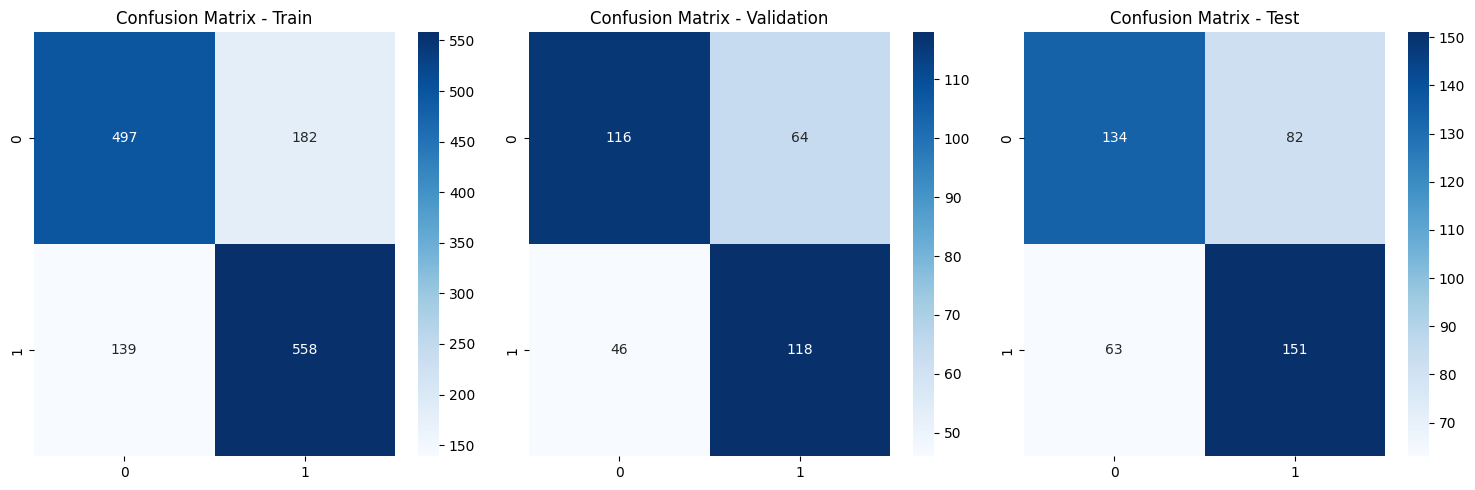

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.766715,0.754054,0.800574,0.776618
Validation,0.680233,0.648352,0.719512,0.682081
Test,0.662791,0.648069,0.705607,0.675615


In [55]:
evaluate_model(up_lrs[0.01], 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 715ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 846ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.753634,0.815141,0.664275,0.732016
Validation,0.654070,0.669173,0.542683,0.599327
Test,0.632558,0.660920,0.537383,0.592784


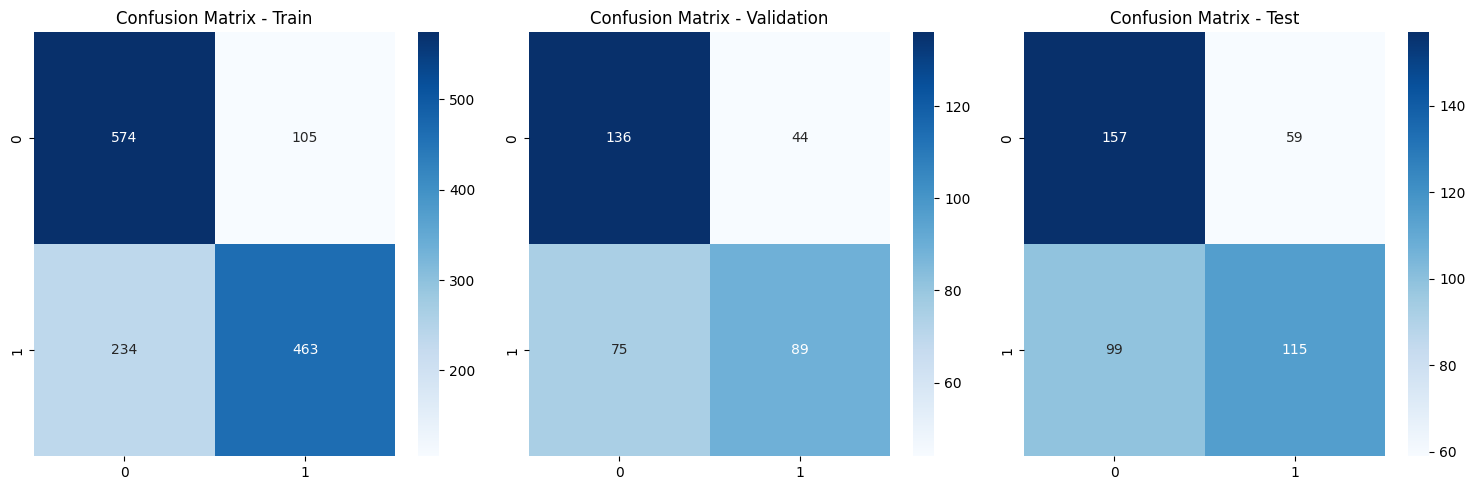

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.753634,0.815141,0.664275,0.732016
Validation,0.654070,0.669173,0.542683,0.599327
Test,0.632558,0.660920,0.537383,0.592784


In [56]:
evaluate_model(up_batches[64], 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 714ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 852ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 669ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.961483,0.939891,0.987088,0.962911
Validation,0.744186,0.691919,0.835366,0.756906
Test,0.723256,0.681992,0.831776,0.749474


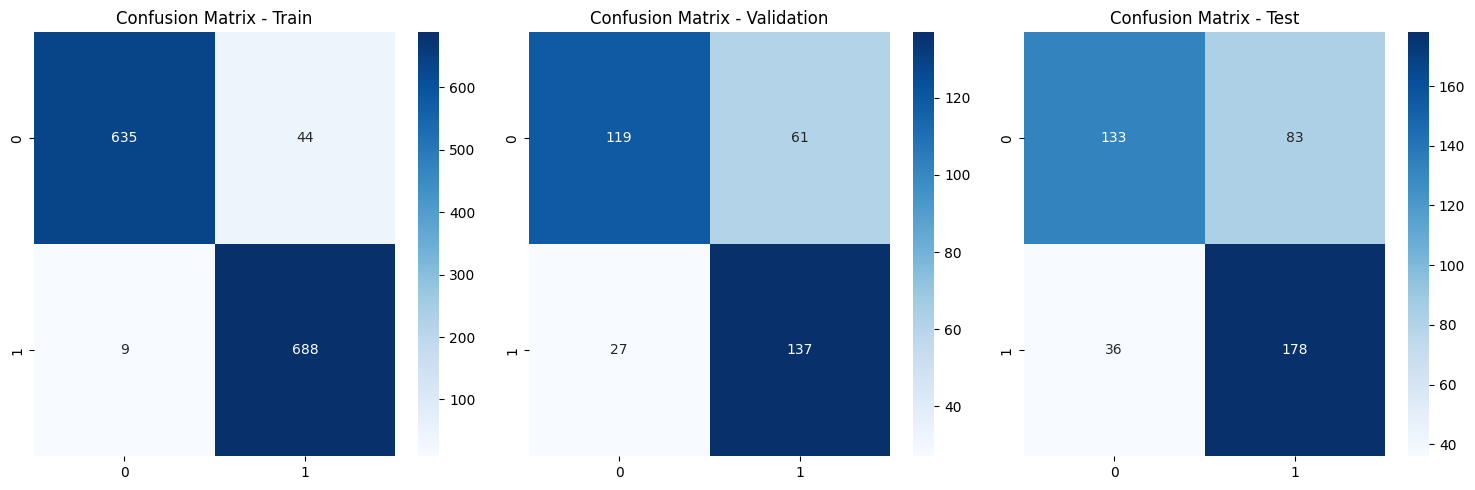

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.961483,0.939891,0.987088,0.962911
Validation,0.744186,0.691919,0.835366,0.756906
Test,0.723256,0.681992,0.831776,0.749474


In [57]:
evaluate_model(up_epochs[70], 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

## Model with All Best Hyperparameters (Upsampling)

In [65]:
model = get_model(0.01)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=64,
                    validation_data=(X_val, y_val))

bestUpModel = model

Epoch 1/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5162 - loss: 2.0628 - val_accuracy: 0.5233 - val_loss: 0.7424
Epoch 2/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5283 - loss: 0.7086 - val_accuracy: 0.5698 - val_loss: 0.6796
Epoch 3/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5699 - loss: 0.6747 - val_accuracy: 0.5407 - val_loss: 0.6752
Epoch 4/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5945 - loss: 0.6619 - val_accuracy: 0.5349 - val_loss: 0.6945
Epoch 5/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6009 - loss: 0.6674 - val_accuracy: 0.5959 - val_loss: 0.6606
Epoch 6/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6699 - loss: 0.6269 - val_accuracy: 0.5930 - val_loss: 0.6575
Epoch 7/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6215 - loss: 0.6406 - val_accuracy: 0.5727 - val_loss: 0.7064
Epoch 8/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6398 - loss: 0.6356 - val_accuracy: 0.5669 - val_loss:

In [66]:
test_loss, test_acc = bestUpModel.evaluate(X_test, y_test)
bestUpTestMetrics = {'loss' : test_loss,
                     'accuracy' : test_acc}

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 676ms/step - accuracy: 0.7053 - loss: 0.8438


43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 799ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 875ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 682ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.942587,0.940171,0.946915,0.943531
Validation,0.732558,0.689474,0.798780,0.740113
Test,0.706977,0.681818,0.771028,0.723684


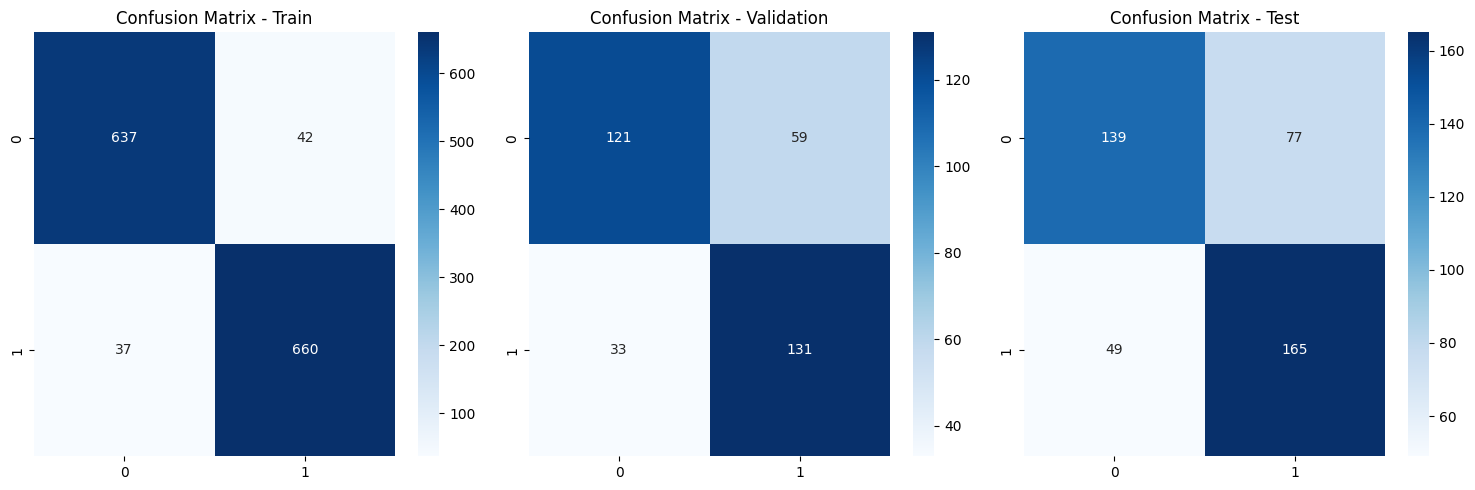

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.942587,0.940171,0.946915,0.943531
Validation,0.732558,0.689474,0.798780,0.740113
Test,0.706977,0.681818,0.771028,0.723684


In [67]:
evaluate_model(bestUpModel, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

# Experiment 3: Multimodal Model

## Preprocessing Tabular data post train-test split (normalizing age)

In [ ]:
scaler = StandardScaler()

#train
age_train = scaler.fit_transform(age_train.reshape(-1,1))

#test
age_val = scaler.transform(age_val.reshape(-1, 1))
age_test = scaler.transform(age_test.reshape(-1, 1))

## 3.1. Hybrid Embedding Fusion Approach

2 Approaches tested:

**Approach 1:**
* This is like our baseline resnet50 model.
* We get the output from the global average pooling layer, which gives us embeddings of dim 128 (we do more dimensionality reduction here; reduces complexity of model)


**Approach 2:**
* We are using pretrained resnet50 (no modifications) to get the embeddings from the second to last layer.
* No dimensionalirty reduction; will retain as mucho info from the image as we can.
* Simpelr model architecture

### APPROACH 1

### Getting Image Embeddings

In [ ]:
base_model_32 = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  #  to get the embeddings
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model and new layers
model_32 = Model(inputs = base_model.input, outputs = x)  #OUTPUT IS X BC EMBEDDINGS ARE IN SECOND TO LAST LAYER

# Extract embeddings from images
image_embeddings_train = model_32.predict(X_train)
image_embeddings_val= model_32.predict(X_val)
image_embeddings_test = model_32.predict(X_test)

image_embeddings_train.shape

14/14 [==============================] - 8s 583ms/step


(1376, 128)

In [ ]:
def train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, penalty='l2', max_iter=2000, threshold = 0.5):

    age_train_reshaped = age_train.reshape(-1, 1)
    age_test_reshaped = age_test.reshape(-1, 1)
    age_val_reshaped = age_val.reshape(-1, 1)

    # Concatenate image embeddings and age data
    X_train_combined = np.concatenate((image_embeddings_train, age_train_reshaped), axis = 1)
    X_test_combined = np.concatenate((image_embeddings_test, age_test_reshaped), axis = 1)

    # Initialize logistic regression model with specified penalty
    logistic_model = LogisticRegression(penalty = penalty, max_iter = max_iter)

    # Train the model
    logistic_model.fit(X_train_combined, y_train)

    #### for metrics
    X_test_combined = np.concatenate((image_embeddings_test, age_test_reshaped), axis = 1)
    X_val_combined = np.concatenate((image_embeddings_val, age_val_reshaped), axis = 1)

    metrics_df = evaluate_model(logistic_model, threshold, X_train_combined, y_train, X_val_combined, y_val, X_test_combined, y_test, include_test = True)

    return logistic_model, test_acc, metrics_df

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.681686,0.673360,0.721664,0.696676
Validation,0.677326,0.666667,0.686391,0.676385
Test,0.665116,0.632653,0.741627,0.682819


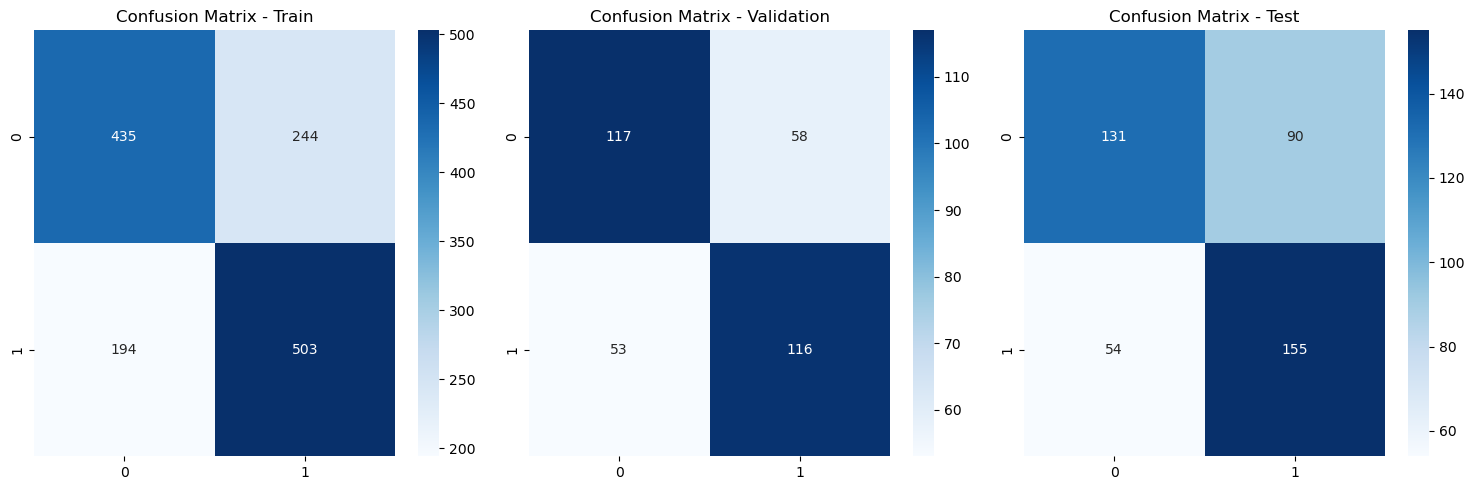

In [ ]:
logistic_model, test_acc, metrics_df = train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, max_iter=2000)

### APPROACH 2

### Getting Image Embeddings

In [ ]:
# Load pre-trained ResNet50 model
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Remove the top layer
x = resnet50.output
x = GlobalAveragePooling2D()(x)

# Create a new model with the desired layers
model = Model(inputs=resnet50.input, outputs=x)

# Freeze the layers
for layer in model.layers:
    layer.trainable = False

# Extract embeddings from images
image_embeddings_train = model.predict(X_train)
image_embeddings_val = model.predict(X_val)
image_embeddings_test = model.predict(X_test)
image_embeddings_train.shape

14/14 [==============================] - 8s 557ms/step


(1376, 2048)

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.851744,0.840000,0.873745,0.856540
Validation,0.735465,0.703125,0.798817,0.747922
Test,0.727907,0.679688,0.832536,0.748387


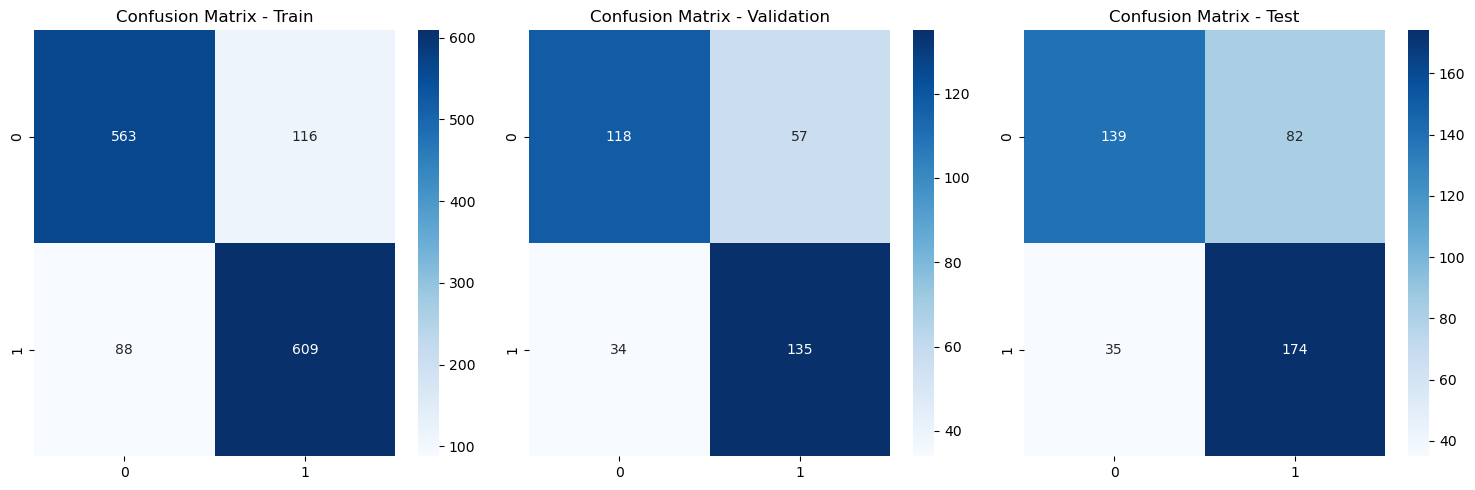

In [ ]:
logistic_model, test_acc, metrics_df = train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, max_iter=2000)

## 3.2. Age-Tailored ResNet Modeling

Age groups for prostate cancer:
* Younger than 50: rare
* 50 - 65: medium
* 65+ more frequent

Age of recommended to start discussions of first screening is at 50 years old if the individual is at average risk (according to the [American Cancer Society] https://www.cancer.org/cancer/types/prostate-cancer/detection-diagnosis-staging/acs-recommendations.html) . However, we don't have many individuals less than 50 years old in our dataset (31 only).

Research has found that prstate cancer is most frequently diagnosed in men aged 65-74.https://seer.cancer.gov/statfacts/html/prost.html So we implemented the cutoff at 65 years old. We fit two distinct models: one for 'low risk/young individuals', one for 'high risk/older individuals'

In [ ]:
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431efd380> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272',
  'age_group': '65+'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431eff450> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908',
  'age_group': '<65'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431eff780> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409',
  'age_group': '65+'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431efe460> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407',
  'age_group': '<65'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 

In [ ]:
balance_checker(dict_images)

Count of 'YES': 425
Count of 'NO': 1075


In [ ]:
def age_group_separator(group):
    new_dict = {}
    for key, entry in dict_images.items():
        if entry['age_group'] == group:
            new_dict[key] = entry
    return new_dict


young_df = age_group_separator('<65')
older_df = age_group_separator('65+')

In [ ]:
len(young_df), len(older_df)

(631, 869)

In [ ]:
balance_checker(young_df)

Count of 'YES': 128
Count of 'NO': 503


In [ ]:
balance_checker(older_df)

Count of 'YES': 297
Count of 'NO': 572


### UPSAMPLING: Balancing the young and older dictionaries for cases of Yes/No Cancer

In [ ]:
young_balanced_ups = balance_dataset(young_df)
older_balanced_ups = balance_dataset(older_df)

In [ ]:
balance_checker(young_balanced_ups)

Count of 'YES': 503
Count of 'NO': 503


In [ ]:
balance_checker(older_balanced_ups)

Count of 'YES': 572
Count of 'NO': 572


### Train test split for young and older df respectively

In [ ]:
X_train_young_ups, X_val_young_ups, X_test_young_ups, y_train_young_ups, y_val_young_ups, y_test_young_ups, age_train_young_ups, age_val_young_ups, age_test_young_ups = preprocess_data(young_balanced_ups)
X_train_old_ups, X_val_old_ups, X_test_old_ups, y_train_old_ups, y_val_old_ups, y_test_old_ups, age_train_old_ups, age_val_old_ups, age_test_old_ups = preprocess_data(older_balanced_ups)

In [ ]:
def build_and_resnet_1img_model(X_train, y_train, X_val, y_val, X_test, y_test, threshold):

    # Load pre-trained ResNet-50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    #freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    #new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

    #combining base model and new layers
    model = Model(inputs = base_model.input, outputs = predictions)

    #compiling model
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    #early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)


    #training
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    #evaluation
    metrics = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

    return model, history, metrics

### Young Model - Upsampling

Epoch 1/10
21/21 [==============================] - 21s 793ms/step - loss: 0.6973 - accuracy: 0.5599 - val_loss: 0.6701 - val_accuracy: 0.5776
Epoch 2/10
21/21 [==============================] - 15s 729ms/step - loss: 0.6654 - accuracy: 0.6159 - val_loss: 0.6608 - val_accuracy: 0.6149
Epoch 3/10
21/21 [==============================] - 15s 724ms/step - loss: 0.6168 - accuracy: 0.6547 - val_loss: 0.6706 - val_accuracy: 0.5466
Epoch 4/10
21/21 [==============================] - 15s 728ms/step - loss: 0.5574 - accuracy: 0.6952 - val_loss: 0.5962 - val_accuracy: 0.6957
Epoch 5/10
21/21 [==============================] - 15s 714ms/step - loss: 0.5470 - accuracy: 0.7061 - val_loss: 0.5588 - val_accuracy: 0.6832
Epoch 6/10
21/21 [==============================] - 15s 709ms/step - loss: 0.5142 - accuracy: 0.7652 - val_loss: 0.5327 - val_accuracy: 0.7081
Epoch 7/10
21/21 [==============================] - 15s 697ms/step - loss: 0.4865 - accuracy: 0.8009 - val_loss: 0.5353 - val_accuracy: 0.7764

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.819596,0.754177,0.960486,0.844920
Validation,0.726708,0.698113,0.860465,0.770833
Test,0.688119,0.589928,0.931818,0.722467


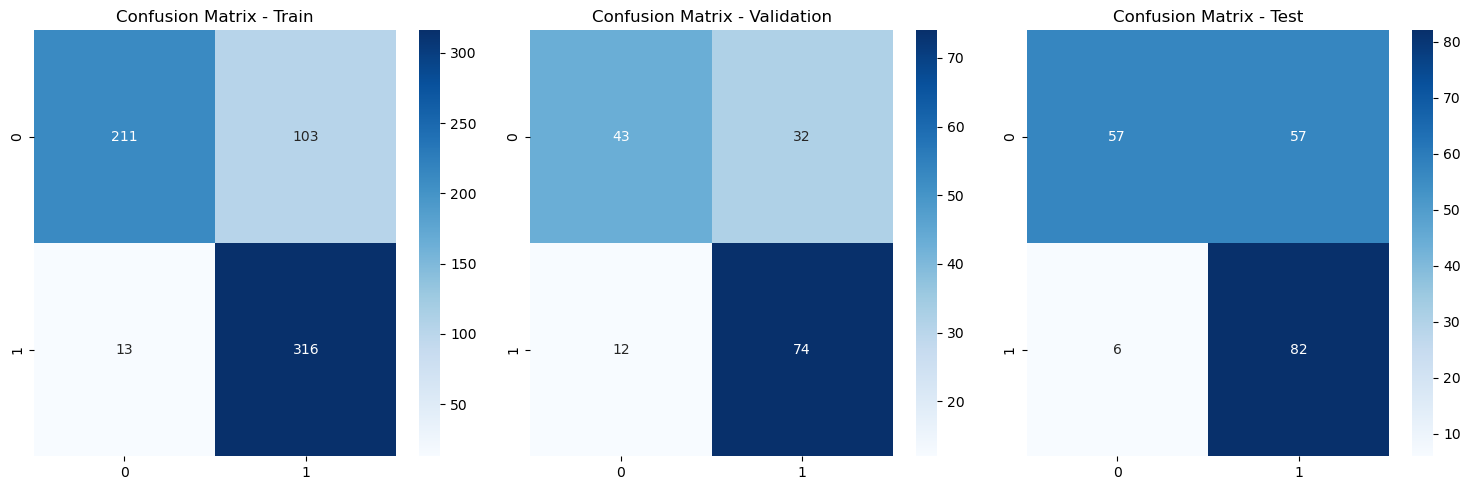

In [ ]:
model_young_ups, history_young_ups, metrics_young_ups = build_and_resnet_1img_model(X_train_young_ups, y_train_young_ups, X_val_young_ups, y_val_young_ups, X_test_young_ups, y_test_young_ups, 0.5)

### Older Model - Upsampling

Epoch 1/10
23/23 [==============================] - 21s 801ms/step - loss: 0.7111 - accuracy: 0.5178 - val_loss: 0.6720 - val_accuracy: 0.5464
Epoch 2/10
23/23 [==============================] - 18s 784ms/step - loss: 0.6566 - accuracy: 0.6079 - val_loss: 0.6564 - val_accuracy: 0.6120
Epoch 3/10
23/23 [==============================] - 19s 851ms/step - loss: 0.6394 - accuracy: 0.6216 - val_loss: 0.6405 - val_accuracy: 0.6612
Epoch 4/10
23/23 [==============================] - 17s 763ms/step - loss: 0.6144 - accuracy: 0.6585 - val_loss: 0.6498 - val_accuracy: 0.5847
Epoch 5/10
23/23 [==============================] - 18s 772ms/step - loss: 0.5918 - accuracy: 0.6749 - val_loss: 0.6443 - val_accuracy: 0.6393
Epoch 6/10
23/23 [==============================] - 17s 757ms/step - loss: 0.5815 - accuracy: 0.7036 - val_loss: 0.6355 - val_accuracy: 0.6448
Epoch 7/10
23/23 [==============================] - 17s 756ms/step - loss: 0.5713 - accuracy: 0.7036 - val_loss: 0.6254 - val_accuracy: 0.6721

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.732240,0.737789,0.753281,0.745455
Validation,0.672131,0.677419,0.677419,0.677419
Test,0.598253,0.525862,0.622449,0.570093


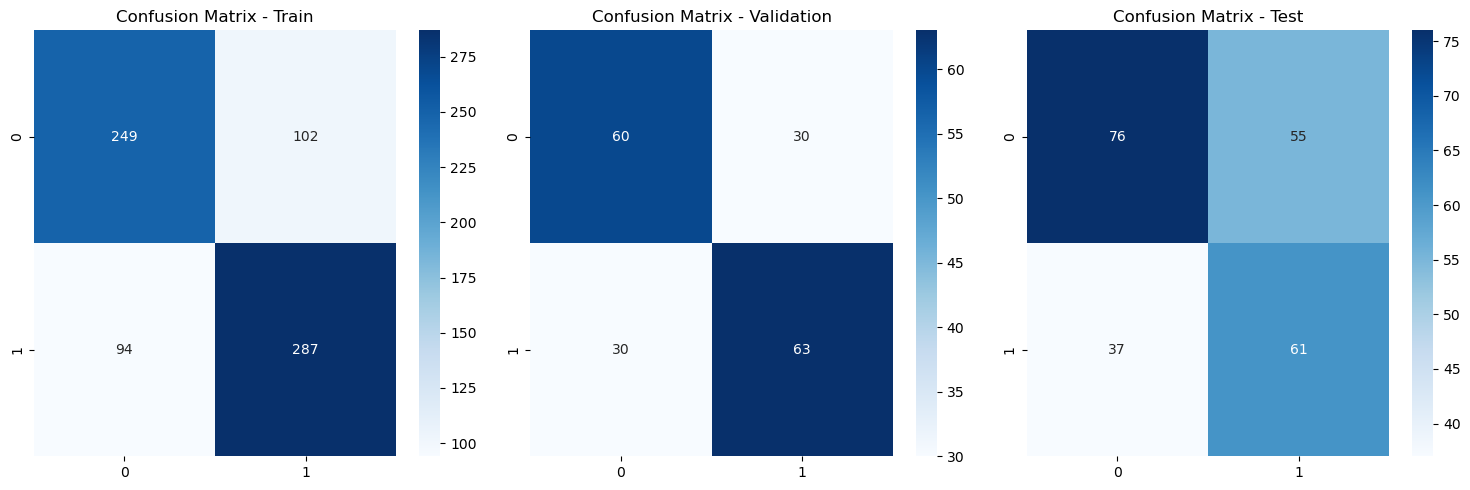

In [ ]:
model_old_ups, history_old_ups, metrics_old_ups = build_and_resnet_1img_model(X_train_old_ups, y_train_old_ups, X_val_old_ups, y_val_old_ups, X_test_old_ups, y_test_old_ups, 0.5)

### DOWNSAMPLING - Balancing the young and older dictionaries for cases of Yes/No Cancer

In [ ]:
young_balanced_down = balance_dataset(young_df, sampling = 'downsampling')
older_balanced_down = balance_dataset(older_df, sampling = 'downsampling')

In [ ]:
balance_checker(young_balanced_down)

Count of 'YES': 128
Count of 'NO': 128


In [ ]:
balance_checker(older_balanced_down)

Count of 'YES': 297
Count of 'NO': 297


#### Train test split

In [ ]:
X_train_young_down, X_val_young_down, X_test_young_down, y_train_young_down, y_val_young_down, y_test_young_down, age_train_young_down, age_val_young_down, age_test_young_down = preprocess_data(young_balanced_down)
X_train_old_down, X_val_old_down, X_test_old_down, y_train_old_down, y_val_old_down, y_test_old_down, age_train_old_down, age_val_old_down, age_test_old_down = preprocess_data(older_balanced_down)

### Young Model - Downsample

Epoch 1/10
6/6 [==============================] - 7s 791ms/step - loss: 0.8425 - accuracy: 0.4724 - val_loss: 0.7146 - val_accuracy: 0.4390
Epoch 2/10
6/6 [==============================] - 4s 690ms/step - loss: 0.6371 - accuracy: 0.6380 - val_loss: 0.7080 - val_accuracy: 0.5366
Epoch 3/10
6/6 [==============================] - 4s 646ms/step - loss: 0.6186 - accuracy: 0.6994 - val_loss: 0.7302 - val_accuracy: 0.5122
Epoch 4/10
6/6 [==============================] - 4s 712ms/step - loss: 0.5918 - accuracy: 0.6933 - val_loss: 0.7732 - val_accuracy: 0.4634
Epoch 5/10
2/2 [==============================] - 1s 410ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.687117,0.708333,0.629630,0.666667
Validation,0.536585,0.571429,0.380952,0.457143
Test,0.576923,0.576923,0.576923,0.576923


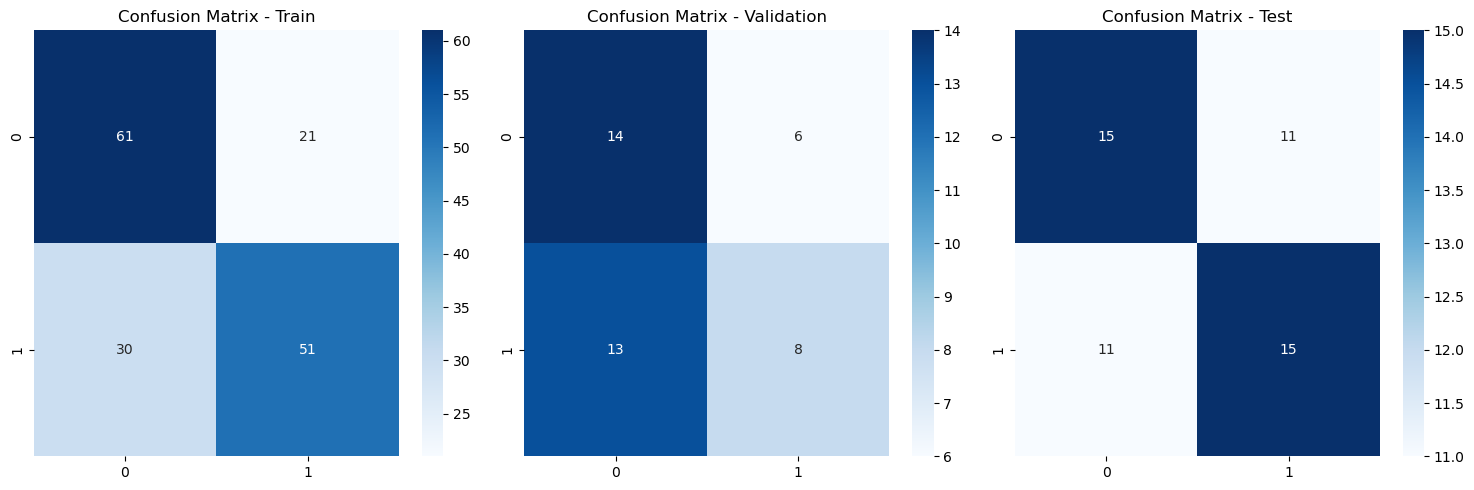

In [ ]:
model_young_down, history_young_down, metrics_young_down = build_and_resnet_1img_model(X_train_young_down, y_train_young_down, X_val_young_down, y_val_young_down, X_test_young_down, y_test_young_down, 0.5)

### Older Model  - Downsample

Epoch 1/10
12/12 [==============================] - 12s 873ms/step - loss: 0.7338 - accuracy: 0.4684 - val_loss: 0.6977 - val_accuracy: 0.5263
Epoch 2/10
12/12 [==============================] - 9s 780ms/step - loss: 0.6941 - accuracy: 0.5447 - val_loss: 0.7139 - val_accuracy: 0.4526
Epoch 3/10
12/12 [==============================] - 9s 790ms/step - loss: 0.6613 - accuracy: 0.5605 - val_loss: 0.6983 - val_accuracy: 0.5158
Epoch 4/10
4/4 [==============================] - 2s 557ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.586842,0.610294,0.443850,0.513932
Validation,0.526316,0.636364,0.274510,0.383562
Test,0.596639,0.622222,0.474576,0.538462


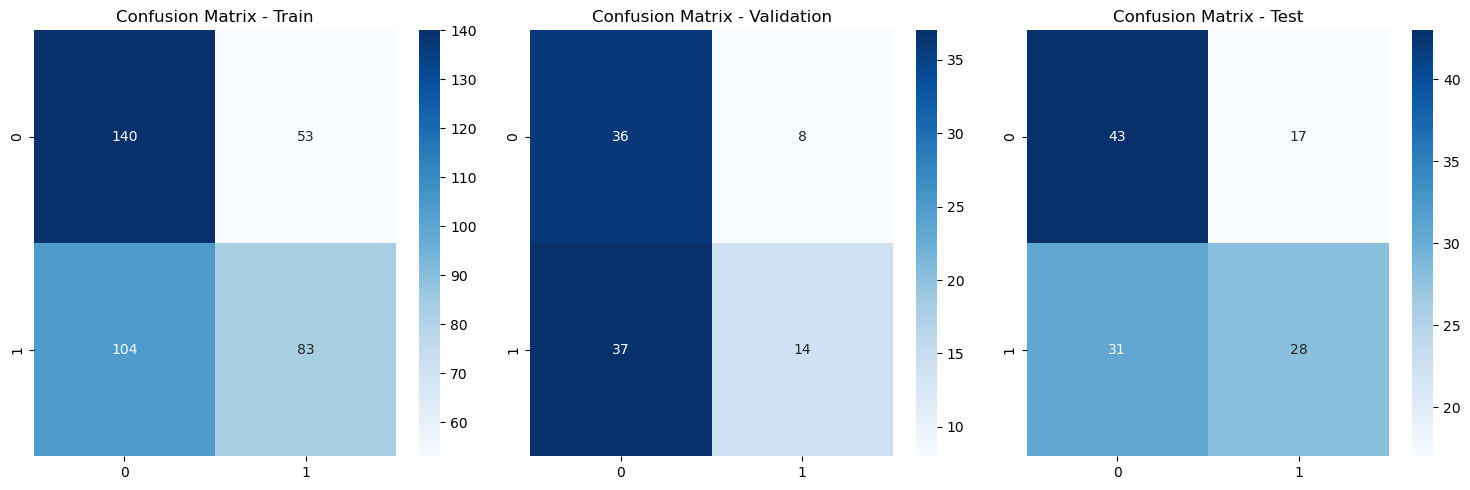

In [ ]:
model_old_down, history_old_down, metrics_old_down = build_and_resnet_1img_model(X_train_old_down, y_train_old_down, X_val_old_down, y_val_old_down, X_test_old_down, y_test_old_down, 0.5)